### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from itertools import product                    
from tqdm import tqdm_notebook

### Import Data

In [2]:
riders = pd.read_csv('Port_Authority_Trans-Hudson__PATH__Monthly_Ridership__Beginning_1996.csv')

### Preview and Convert to Usable Data

In [3]:
riders.head()

,Year,Month,Total Trips
0,01/01/1996,1,4812000
1,02/01/1996,2,4789000
2,03/01/1996,3,5119000
3,04/01/1996,4,5212000
4,05/01/1996,5,5303000


In [4]:
#rename the year column to month_year column
riders.rename(columns={'Year': 'Month_year'}, inplace=True)

In [5]:
#convert to datetime and set index to month_year column
riders.index = pd.to_datetime(riders['Month_year'])

In [6]:
#drop non-index month_year column and month columns
riders.drop(['Month_year', 'Month'], axis=1, inplace=True)

### Initial Visualization

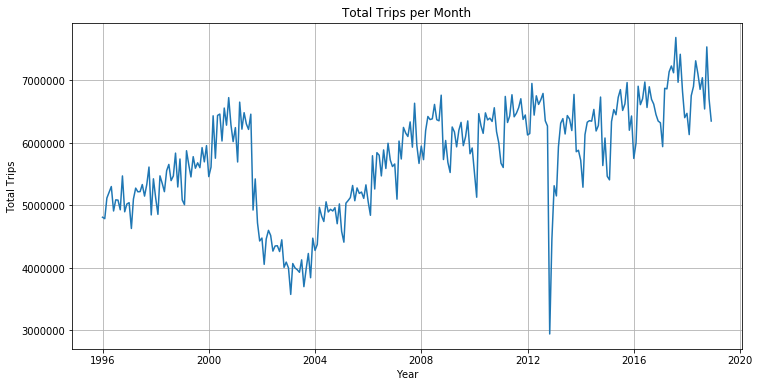

In [7]:
#plotting entire dataset
plt.figure(figsize=(12, 6))
plt.plot(riders['Total Trips'])
plt.title('Total Trips per Month')
plt.xlabel('Year')
plt.ylabel('Total Trips')
plt.grid(True)
plt.show()

Initial interpretation of the plot shows trend and annual seasonality. This series is non-stationary. You can
also see two anomalies in the data - a dip in ridership after 9/11 and a dip 
after Superstorm Sandy. To take a closer look at seasonality, I am going to just 
plot the first 10 years of data.

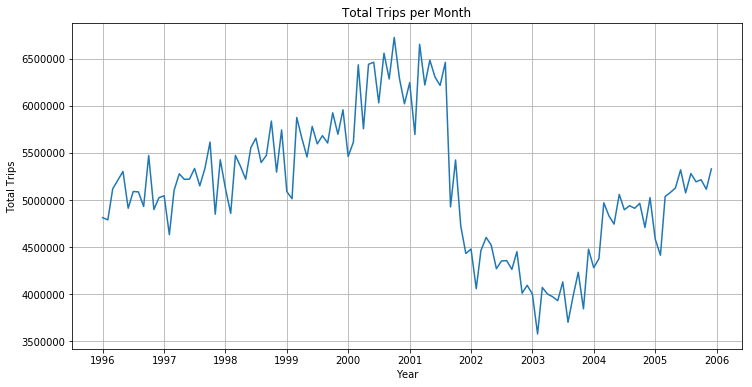

In [8]:
#plotting 10 years to get a closer look at seasonality
plt.figure(figsize=(12, 6))
plt.plot(riders['Total Trips'][:120])
plt.title('Total Trips per Month')
plt.xlabel('Year')
plt.ylabel('Total Trips')
plt.grid(True)
plt.show()

### Making Series Stationary - Removing Trend, Seasonality, Autocorrelation 

In [9]:
""" 
The Dickey-Fuller Test is a statistical test that is run to determine if 
a series is stationary or not. Null hypothesis - unit root is present and 
the time series is non stationary. The alternative hypothesis is that the
time series is stationary. If p > 0, the process is not stationary and you 
fail to reject the null hypothesis. Otherwise, p = 0, the null hypothesis 
is rejected, and the process is considered to be stationary.
"""

# Function to view series, autocorrelation (ACF) and partial autocorrelation (PACF)

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
    Plot time series, its ACF and PACF
    Calculate Dickey-Fuller Test
    
    y = time series
    lags = how many lags to include in ACF, PACF calculation
    """
    
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

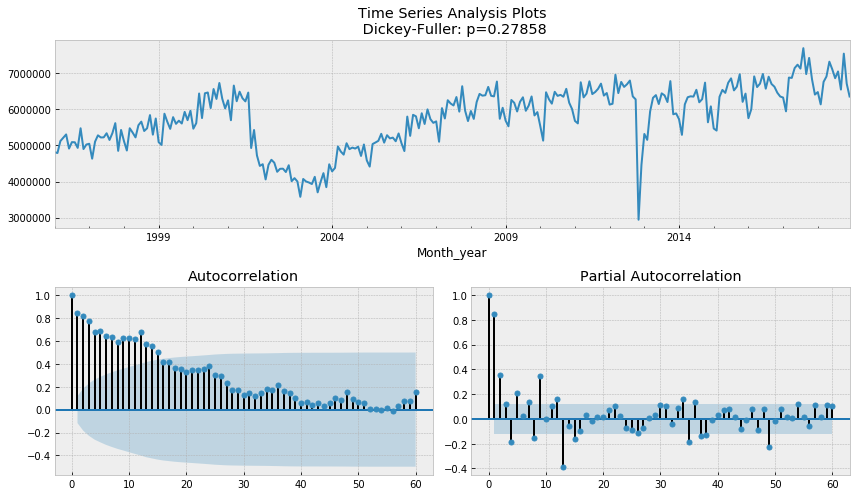

In [10]:
tsplot(riders['Total Trips'], lags=60)

Removing seasonality - 

to remove seasonality, we are going to take the 'seasonal difference' (in this case - annual
seasonality), which is a simple subtraction of the series from itself with a lag that 
equals the seasonal period.

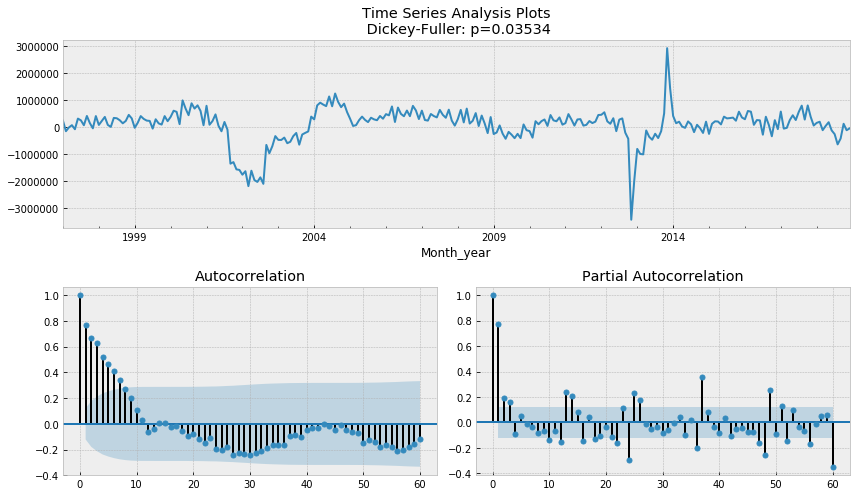

In [11]:
riders_diff = riders['Total Trips'] - riders['Total Trips'].shift(12)
tsplot(riders_diff[12:], lags=60)

Removing Autocorrelation -

the autocorrelation function still has too many lags - to remove 
autocorrelation, I will take a first difference - subtracting the 
series from itself with lag 1.

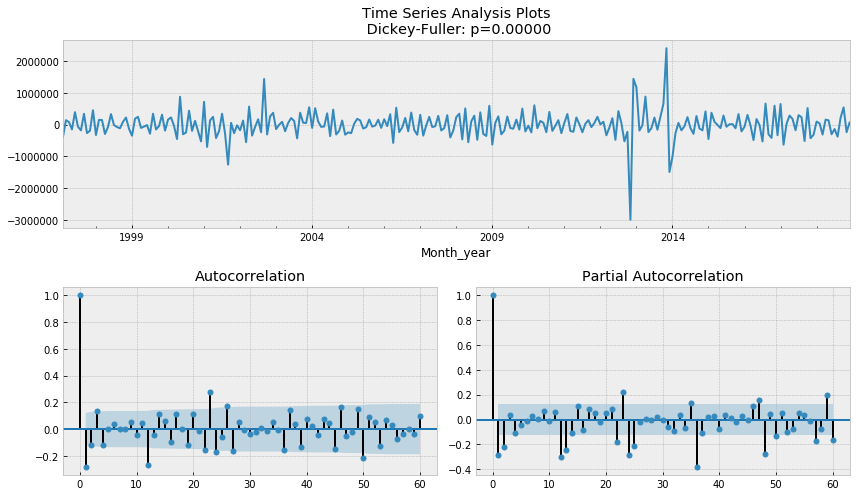

In [12]:
riders_diff = riders_diff - riders_diff.shift(1)
tsplot(riders_diff[12+1:], lags=60)

Our data now looks like it is ready to be modeled - the Dickey-Fuller test shows no trends,
the mean and standard deviation appear constant and there doesn't appear to be any
autocorrelation.

### Optimizing The Parameters (p, d, q, P, D, Q, and s)

In [13]:
""" creating a parameters list with different p, d, q, P, D, Q 
values """

ps = range(1, 3)
d = range(1, 2)
qs = range(1, 4)
Ps = range(1, 3)
D = range(1, 2)
Qs = range(1, 2)
s = 12 # season length is still 12

# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs, Ps, D, Qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [14]:
"""splitting the data into train/test: train is the first 80%
of the series and the test is the last 20%"""

riders_train = riders[:(int(len(riders)*0.8))]
riders_test = riders[(int(len(riders)*0.8)):]

In [15]:
""" function to calculate and find the lowest AIC using the 
# different p, d, q, P, D, Q parameter values """ 

def optimizeSARIMA(param_list, s):
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(param_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(riders_train, order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [16]:
#create parameters/AIC table

result_table = optimizeSARIMA(parameters_list, s)
result_table.head()

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,parameters,aic
0,"(2, 1, 3, 2, 1, 1)",5915.854108
1,"(2, 1, 3, 1, 1, 1)",5916.460978
2,"(2, 1, 1, 2, 1, 1)",5921.049970
3,"(1, 1, 2, 2, 1, 1)",5921.890772
4,"(1, 1, 1, 2, 1, 1)",5922.364562


In [17]:
# set the parameters that give the lowest AIC

p, d, q, P, D, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(riders_train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Total Trips   No. Observations:                  220
Model:             SARIMAX(2, 1, 3)x(2, 1, 1, 12)   Log Likelihood               -2948.927
Date:                            Tue, 03 Sep 2019   AIC                           5915.854
Time:                                    15:09:32   BIC                           5945.849
Sample:                                01-01-1996   HQIC                          5927.984
                                     - 04-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1520      0.011   -107.592      0.000      -1.173      -1.131
ar.L2         -0.9904      0.022   

Inspecting the residuals of the model with:
p = 2,
d = 1,
q = 3,
P = 2,
D = 1,
Q = 1,
s = 12:

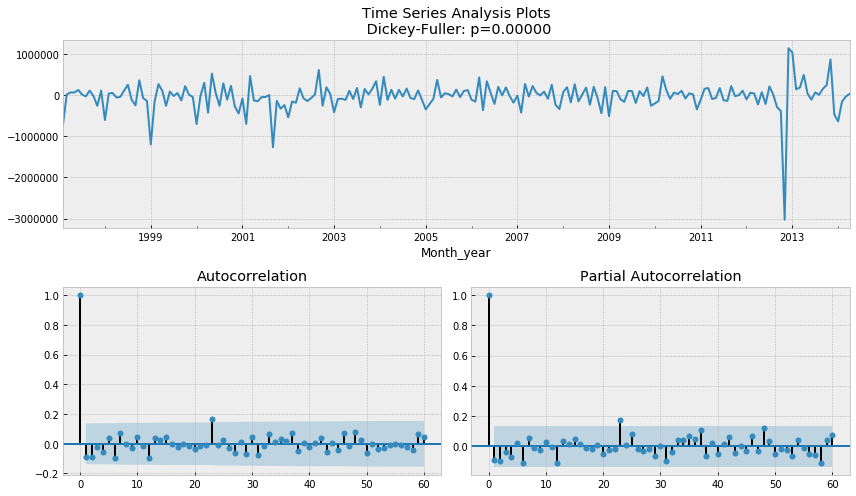

In [18]:
tsplot(best_model.resid[12+1:], lags=60)

The residuals are stationary and there doesn't appear to be any autocorrelation.
I can move on to forecasting.

### Forecasting Using SARIMA

In [19]:
# going to use the mean absolute error (MAE)
# to measure the quality of our predictions

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
# training set forecasting function

def plotSARIMAtraining(series, model, n_steps):
    
    #train/test split
    data = series.copy()
    data_train = data[:(int(len(data)*0.8))]
    data_test = data[(int(len(data)*0.8)):]
    data_test.columns = ['actual']
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data_train.shape[0], end = data_train.shape[0]+n_steps-1)
    forecast = pd.DataFrame(forecast, columns=['arima_model'])
    forecast.dropna(inplace=True)
    arima_forecast = pd.concat([forecast, data_test], axis=1)
    
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(arima_forecast['actual'], arima_forecast['arima_model'])
    
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    #plt.plot(series, color='b', label='actual')
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data_test.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data, label="actual")
    plt.legend()
    plt.grid(True);

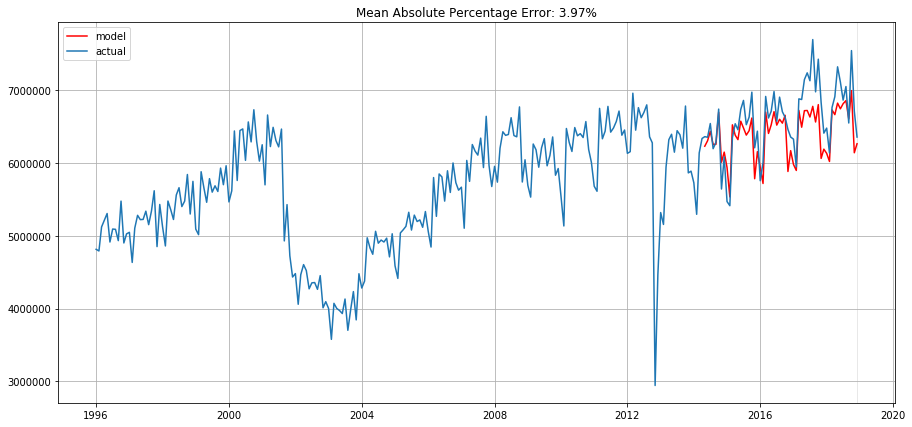

In [21]:
plotSARIMAtraining(riders, best_model, 56)

In [22]:
# forecasting function

def plotSARIMA(series, model, n_steps):
    """ 
    series = dataset with timeseries
    model = fitted SARIMA model
    n_steps = number of steps to predict into the future
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps, dynamic=True)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast[data.shape[0]:], color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [23]:
# set the parameters that give the lowest AIC
p, d, q, P, D, Q = result_table.parameters[0]

final_model=sm.tsa.statespace.SARIMAX(riders, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(final_model.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Total Trips   No. Observations:                  276
Model:             SARIMAX(2, 1, 3)x(2, 1, 1, 12)   Log Likelihood               -3727.263
Date:                            Tue, 03 Sep 2019   AIC                           7472.526
Time:                                    15:09:56   BIC                           7504.675
Sample:                                01-01-1996   HQIC                          7485.446
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1536      0.007   -172.012      0.000      -1.167      -1.140
ar.L2         -0.9965      0.011   

### Forecasting PATH Ridership Into 2024

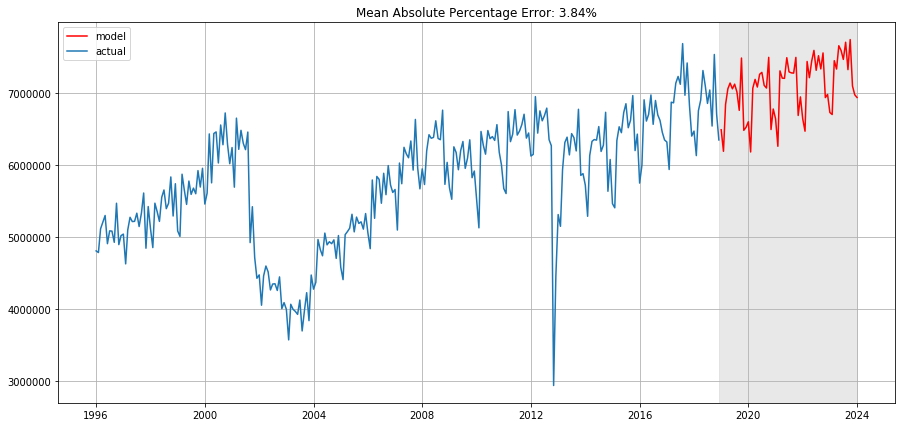

In [24]:
plotSARIMA(riders, final_model, 60)